Here we have a function that returns the new cost/reward price given any input of deposit or withdrawl. 

In [1]:
import pandas as pd

In [2]:
def motion(bid, state):
    '''
    returns price of asset given a current state and a proposed deposit (or withdrawal)
    
    Wait, this must make some assumptions - 
    '''
    import math
    c = state['existing credits']
    s = state['existing other units']
    e = state['existing asset units']
    d = bid
    try:
        calculation = float(
            (math.sqrt(c**2 * d * s + e * c**2 * s ) - e * c * s) 
            / (d - e**2 * s + e))
    except ZeroDivisionError:
        calculation = 0
    return calculation

In [3]:
state = {'existing credits': 2, 'existing other units': 1, 'existing asset units': 1}

In [4]:
motion(1, state)

0.8284271247461903

In [5]:
motion(2, state)

0.7320508075688772

for a realistic example: if there are 100 btc in the system and btc makes up half the value of the sysetm and I want to trade .1 btc I'm basically paying a fee of:

In [6]:
1-motion(.001, state)

0.0002498750780732806

lets see the curve

<AxesSubplot:>

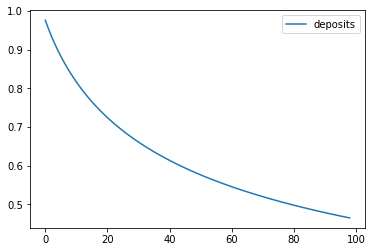

In [7]:
deposits = []
for i in range(1, 100):
    deposits.append(motion(i/10, state))
pd.DataFrame({'deposits': deposits}).plot()

<AxesSubplot:>

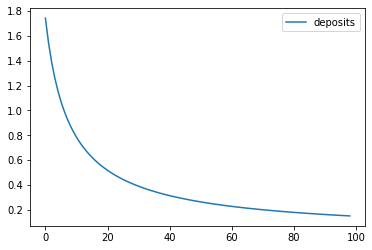

In [8]:
deposits = []
for i in range(1, 100):
    deposits.append(motion(1, {**state, **{'existing asset units': i/10}}))
pd.DataFrame({'deposits': deposits}).plot()

<AxesSubplot:>

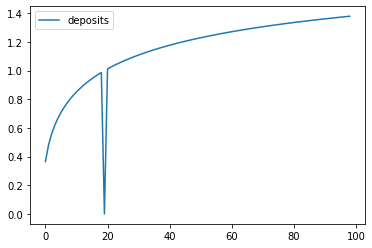

In [9]:
deposits = []
for i in range(1, 100):
    deposits.append(motion(1, {**state, **{'existing other units': i/10}}))
pd.DataFrame({'deposits': deposits}).plot()

<AxesSubplot:>

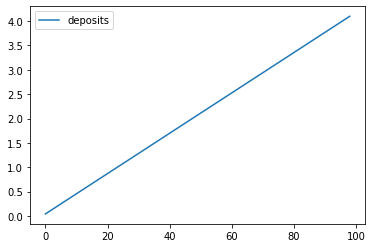

In [10]:
deposits = []
for i in range(1, 100):
    deposits.append(motion(1, {**state, **{'existing credits': i/10}}))
pd.DataFrame({'deposits': deposits}).plot()

what if we withdraw?

In [11]:
motion(-.1, state)

1.0263340389897238

In [12]:
motion(-.2, state)

1.0557280900008417

<AxesSubplot:>

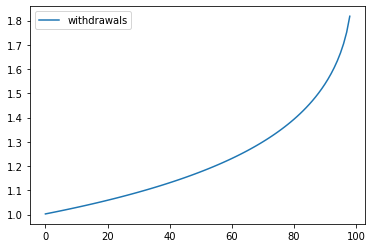

In [13]:
withdrawals = []
for i in range(1, 100):
    withdrawals.append(motion(-1*i/100, state))
pd.DataFrame({'withdrawals': withdrawals}).plot()

In [14]:
motion(-1, state)

2.0

In [15]:
motion(-.9, state)

1.519493853295916

In [16]:
motion(-.8, state)

1.3819660112501053

In [17]:
motion(-.999, state)

1.9386931399365688

how interesting... not sure this is right... fees increase differently... lets just look at the curvature of the fee progression in order to get a feel for the relationship

<AxesSubplot:>

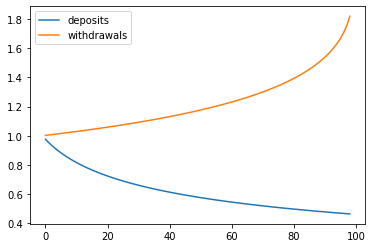

In [47]:
deposits = []
for i in range(1, 100):
    deposits.append(motion(i/10, state))
withdrawals = []
for i in range(1, 100):
    withdrawals.append(motion(-1*i/100, state))
pd.DataFrame({'deposits': deposits, 'withdrawals': withdrawals}).plot()

now lets look at them to scale so the curavture will go away a little. So if you depoit a 100% of another unit you'll get paid 80%, if you withdraw the single unit in the index, you'll have to pay 

<AxesSubplot:>

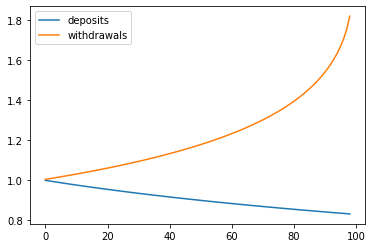

In [49]:
deposits = []
for i in range(1, 100):
    deposits.append(motion(i/100, state))
withdrawals = []
for i in range(1, 100):
    withdrawals.append(motion(-1*i/100, state))
pd.DataFrame({'deposits': deposits, 'withdrawals': withdrawals}).plot()

Truly this isn't right. if you want to pull the whole thing out it'll cost you at a rate of about 2. so you'll get 1 unit of the asset in return but you'll pay 2 index tokens. If you want to pull half the asset out get a rate of 1.15, and you'll only get half the asset, so 1.15*.5 = 0.575 index cost. There is an arument to be made that there should be no increase on withdrawals because you want to be able to withdraw all assets. One way to potentially solve this is to mint 1 index token in the genesis block which is irretrievable. more experiamentation is needed.

since, in this simulation 1 deposit represents a doubling of the current assets we should probably zoom in to witness the spread where it would have its most common effect. most transactions will amount to a tiny percentage of the held asset. when we zoom in to this amount we can't see any curvature, and they look like they are the same.

buying  0.0001 while selling 0.0001


<AxesSubplot:>

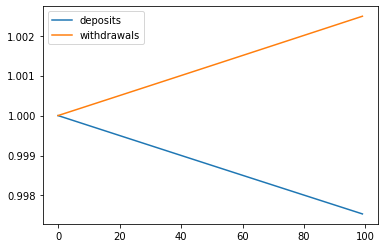

In [66]:
deposits = [1]
for i in range(1, 10000):
    deposits.append(motion(i/10000, state))
withdrawals = [1]
for i in range(1, 10000):
    withdrawals.append(motion(-1*i/10000, state))
print('buying ', 1/10000, 'while selling', 1/10000)
pd.DataFrame({'deposits': deposits, 'withdrawals': withdrawals})[0:100].plot()

at index 0, representing a trade of 0.0000% of half of the assets held by the system, the price is exactly the same

In [67]:
withdrawals[0]

1

In [68]:
deposits[0]

1

but as we move away from that non-transaction amount we start to get a spread

In [69]:
withdrawals[1]

1.0000250012499592

In [70]:
deposits[1]

0.9999750012480426

i think the vote has some kind of an effect like this. modifying the rate of curvature of either side. Not sure...

<AxesSubplot:>

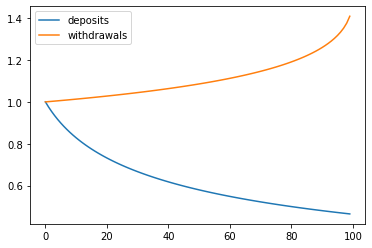

In [74]:
deposits = [1]
for i in range(1, 100):
    deposits.append(motion(i/10, state))
withdrawals = [1]
modifier = .5  # not sure how to come up with this... it's half of a theoretical 0 deposit
vote = 2
for i in range(1, 100):
    withdrawals.append(motion(-1*i/100, state) / vote + modifier)
pd.DataFrame({'deposits': deposits, 'withdrawals': withdrawals}).plot()

maybe we could flip it around... but how?

lets try the other formula

In [20]:
def withdraw(d, state):
    ''' returns cost '''
    import math
    c = state['existing credits']
    s = state['existing other units']
    e = state['existing asset units']
    try:
        calculation = float(
            (e * (-1*c) * s - math.sqrt(c**2 * d * s + e * c**2 * s))
            /(d - e**2 * s + e))
    except ZeroDivisionError:
        calculation = 0
    return calculation

In [21]:
withdraw(1, state)

-4.82842712474619

ok, that's garbage

In [22]:
withdraw(-.5, state)

6.82842712474619

huh?

In [23]:
withdraw(4, state)

-1.618033988749895

what is phi doing here?

<AxesSubplot:>

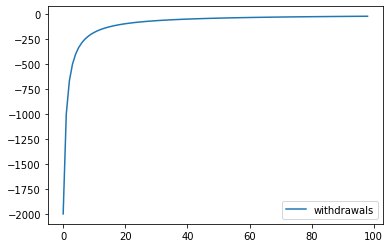

In [24]:
withdrawals = []
for i in range(1, 100):
    withdrawals.append(withdraw(i/500, state))
pd.DataFrame({'withdrawals': withdrawals}).plot()

well, that seems like it's closer to the predicted shape, but I really don't know what's going on here...

Maybe this doesn't matter. so what if people have more of an incentive to withdraw. they do anyway. people will always tend to withdraw in large numbers and deposit in small number anyway. 

so anyway, we found the formula that will always keep the system in balance, now we need to change that formula so that it can be modified by the vote.

does the vote really just come down to a factor? or two factors?

I think one cool thing about this is that the vote can modify either curve separately. if people vote to attract this asset it could just modify the deposit curve. if they vote to repell the asset it can flatten the withdrawal... if they want both...

Thats one way to think about it. another way to think about it is to say, it doesn't change the curves directly, it changes the priors that define the curve. meaning. this curve is with no priors, saying, we want to keep everything in balance. but what if we don't want to keep things in balance? then the curves change.